In [133]:
from tensorflow.keras.applications.vgg19 import preprocess_input,decode_predictions
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import models
#conv5/conv5_2 unit 148
#VGG 19
#Data from https://github.com/fastai/imagenette?tab=readme-ov-file
vgg = tf.keras.applications.VGG19()

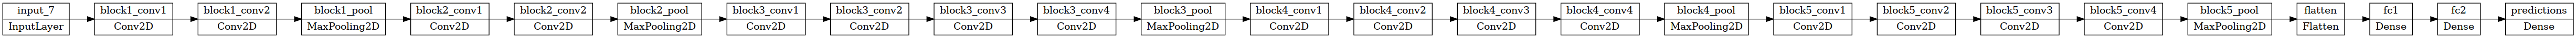

In [134]:
tf.keras.utils.plot_model(vgg,rankdir='LR')

In [135]:
vgg.input_shape

(None, 224, 224, 3)

# Image Processing

In [132]:
def prepare_image_for_display(img, norm_type='max'):
    if norm_type == 'max':
        # min/max scaling, best for regular images
        new_img = (img - img.min()) / (img.max()-img.min())
    else:
        # std scaling, best when we are unsure about large outliers
        new_img = ((img - img.mean()) / (img.std() +1e-3))*0.15 + 0.5
        
    new_img *= 255
    new_img = np.clip(new_img, 0, 255)
    
    if len(new_img.shape)>3:
        new_img = np.squeeze(new_img)
        
    return new_img.astype('uint8')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


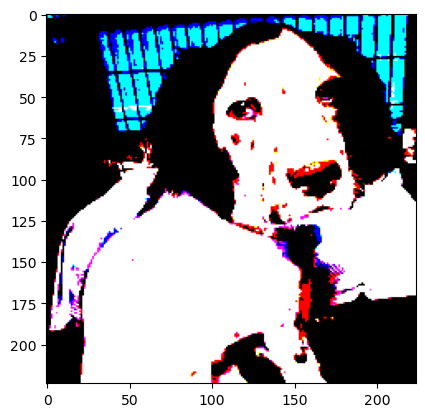

In [53]:
def load_image_for_processing(filepath,prep_for_vgg=True):
    img = Image.open(filepath)
    img = img.resize(size=(vgg.input_shape[1],vgg.input_shape[2])) #reisze to model's input expectation (can change model input and this still works)
    img = np.array(img)
    if prep_for_vgg:
        img = preprocess_input(img)
    return img



plt.imshow(load_image_for_processing('/mnt/c/Users/alexs/ML/Proj3/ML_Conv_Visuals/imagenette2-320/train/n02102040/ILSVRC2012_val_00016833.JPEG',prep_for_vgg=True))

In [64]:
def get_example_images(directory_path,num_classes=2,num_examples_per_class=10,prep_for_vgg=False):
    possible_classes = os.listdir(directory_path)
    num_classes = min(len(possible_classes),num_classes)
    chosen_classes = np.random.choice(possible_classes,size=num_classes,replace=False)
    print(f'Classes Chosen: {chosen_classes}')
    data = []
    for cls in chosen_classes:
        cls_pth = os.path.join(directory_path,cls)
        images = os.listdir(cls_pth)
        images = np.random.choice(images,size=min(num_examples_per_class,len(images)),replace=False)
        for img in images:
            img_pth = os.path.join(cls_pth,img)
            data.append(load_image_for_processing(img_pth,prep_for_vgg=prep_for_vgg))
    return np.array(data)


result = get_example_images('/mnt/c/Users/alexs/ML/Proj3/ML_Conv_Visuals/imagenette2-320/train',num_classes=3)

Classes Chosen: ['n03445777' 'n03888257' 'n02979186']


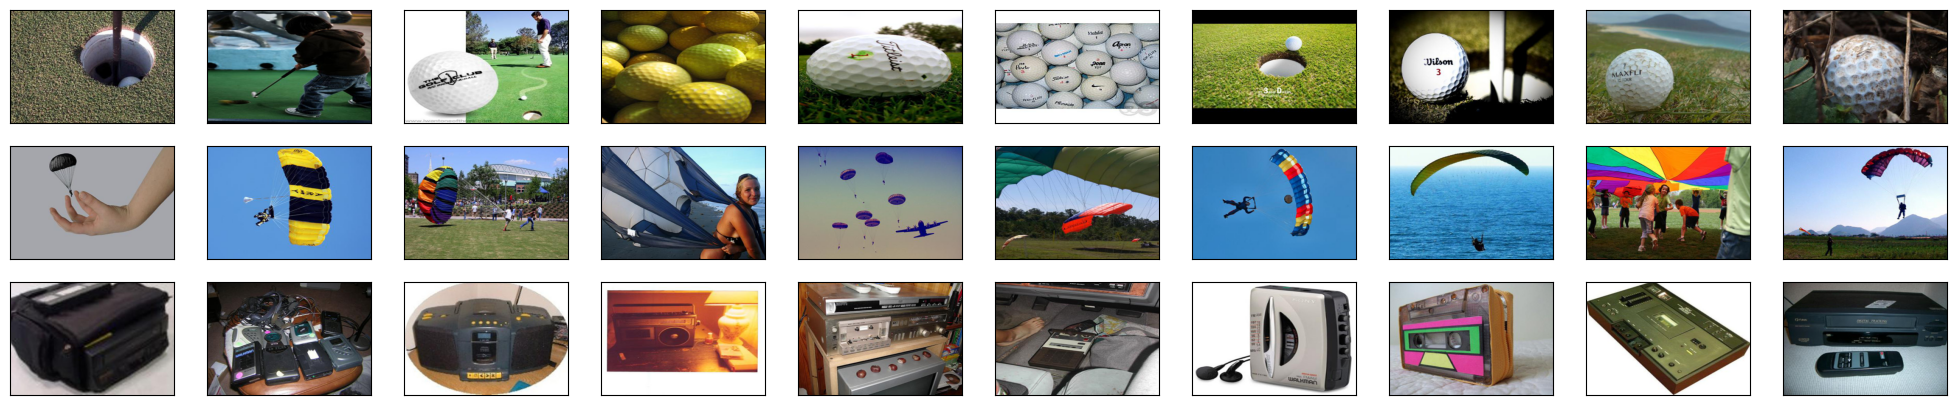

In [130]:
def display_images(imgs,num_rows=3,figsize=(25,5)):
    num_cols = int(np.ceil(float(len(imgs)/num_rows)))
    fig, axs = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=figsize)
    for ax,img in zip(axs.flatten(),imgs):
        ax.imshow(img,aspect='auto')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    # plt.subplots_adjust(wspace=0, hspace=0)
    
display_images(result,num_rows=3)

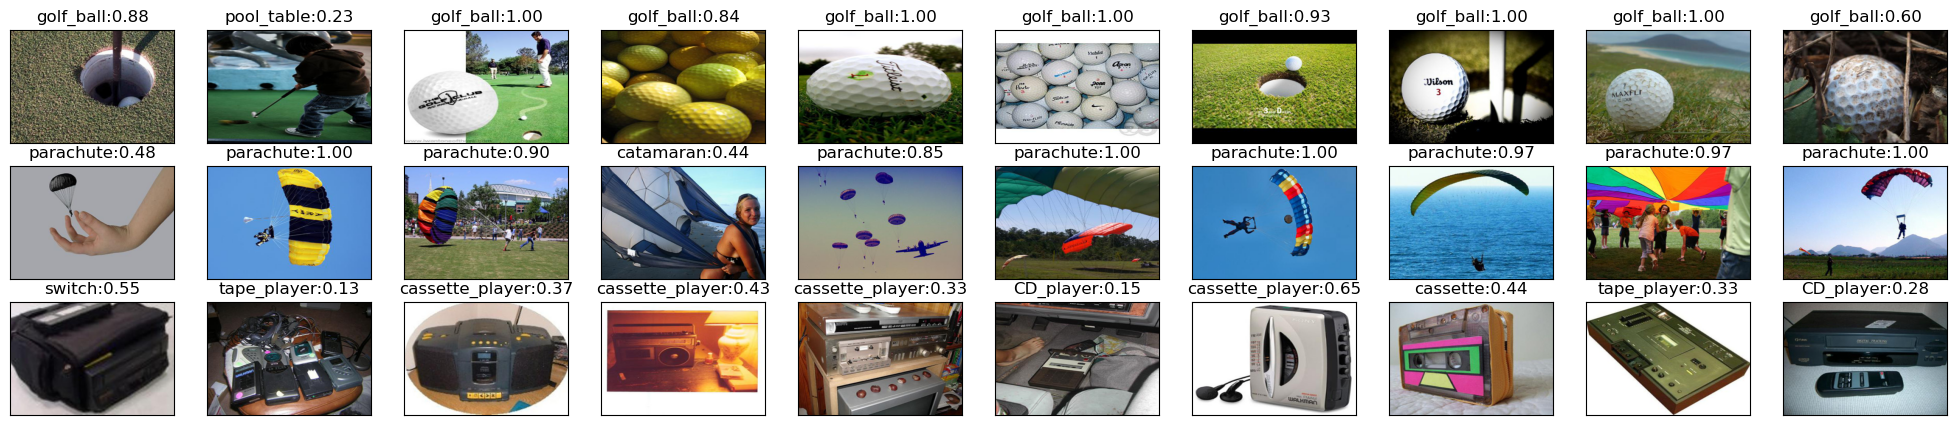

In [131]:
def display_images_with_prediction(imgs,num_rows=3,figsize=(25,5)):
    ready_images = np.array([preprocess_input(x) for x in imgs])
    # return ready_images
    preds = vgg(ready_images).numpy()
    preds = decode_predictions(preds)
    num_cols = int(np.ceil(float(len(imgs)/num_rows)))
    fig, axs = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=figsize)
    for ax,img,pred in zip(axs.flatten(),imgs,preds):
        ttl = pred[0][1]
        prob = round(pred[0][2],ndigits=2)
        
        ax.imshow(img,aspect='auto')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'{ttl}:{prob:0.2f}')
    # plt.subplots_adjust(wspace=0.2, hspace=3)

tmp = display_images_with_prediction(result,num_rows=3)

# Modeling

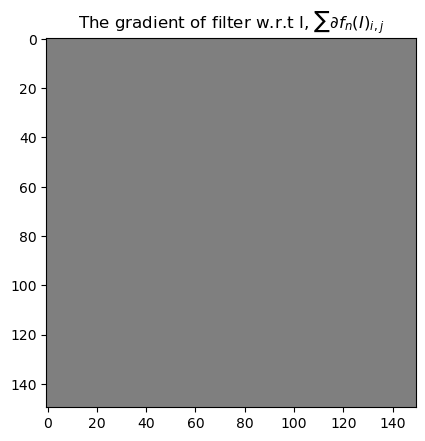

In [137]:
model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=None)

# set VGG to be frozen
for layer in model.layers:
    layer.trainable = False

# Selecting a layer and channel to visualize
layer_name = 'block5_conv2'
filter_index = 0

# Isolate the output of interest and create new model
layer_output = model.get_layer(layer_name).output
new_model = models.Model(inputs=model.input, outputs=layer_output)
# now "new_model" has the output we desire to maximize

# create a variable that we can access and update in computation graph
I = tf.Variable(np.zeros((1, 150, 150, 3),dtype='double'), name='image_var', dtype = 'float64')

# now use gradient tape to get the gradients (watching only the variable v)
with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(I) # watch
    model_vals = new_model(preprocess_input(I)) # get output
    filter_output_to_maximize = tf.reduce_mean(model_vals[:, :, :, filter_index]) # define what we want to maximize
    
grad_fn = tape.gradient(filter_output_to_maximize, I) # get gradients that influence loss w.r.t. v
grad_fn /= (tf.sqrt(tf.reduce_mean(tf.square(grad_fn))) + 1e-5) # mean L2 norm (better stability)

# now show the gradient, same size as input image
plt.imshow(prepare_image_for_display( grad_fn.numpy(), norm_type='std'))
plt.title('The gradient of filter w.r.t I, $ \sum\partial f_n(I)_{i,j} $ ')
plt.show()

In [154]:
def generate_pattern(layer_name, filter_index, size=150,epochs=40):
    # Build a model that outputs the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    # Isolate the output 
    new_model = models.Model(inputs=model.input, outputs=layer_output)
    
    # We start from a gray image with some uniform noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    I_start = tf.Variable(input_img_data, name='image_var', dtype = 'float64')
    I = preprocess_input(I_start) # only process once
    # Run gradient ascent for 40 steps
    eta = 1.
    for i in range(epochs):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(I)
            # get variable to maximize 
            model_vals = new_model(I) 
            filter_output = tf.reduce_mean(model_vals[:, :, :, filter_index])

        # Compute the gradient of the input picture w.r.t. this loss
        # add this operation input to maximize
        grad_fn = tape.gradient(filter_output, I)
        # Normalization trick: we normalize the gradient
        grad_fn /= (tf.sqrt(tf.reduce_mean(tf.square(grad_fn))) + 1e-5) # mean L2 norm
        I += grad_fn * eta # one iteration of maximizing
        
    # return the numpy matrix so we can visualize 
    img = I.numpy()
    return prepare_image_for_display(img, norm_type='std')

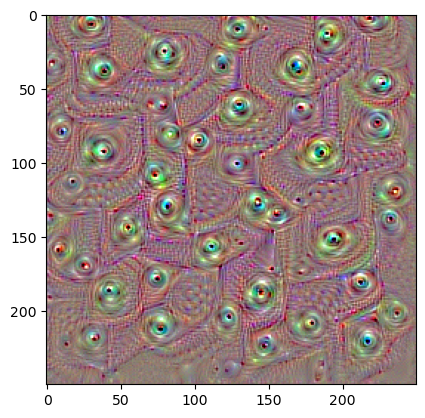

In [166]:
plt.imshow(generate_pattern('block5_conv2', 63, size=250,epochs=40))
plt.show()